In [2]:
from dotenv import load_dotenv
import os
import uuid
import chromadb
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from chromadb.utils import embedding_functions
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain_core.messages import HumanMessage, SystemMessage
# from kiwipiepy import Kiwi
import time
import csv

In [3]:
# api key
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [4]:
# pip install -qU langchain-teddynote

In [5]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("240717") #set_enable=False

LangSmith 추적을 시작합니다.
[프로젝트명]
240717


In [6]:
YOUR_LANSMITH_PROJECTNAME = "240717"

In [7]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI()
# # 간단하게 API 텍스트 호출
# llm.invoke("LangSmith로 Testing과 Evaluation을 어떻게 할 수 있어?")

In [8]:
## 컬렉션 생성/연결하기
import chromadb
client = chromadb.PersistentClient('chroma/')
client.list_collections()

[Collection(name=12_files_openai_3072), Collection(name=csv_files_openai_3072)]

### Retriever

In [9]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
collection_names = ["csv_files_openai_3072", "12_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

/Users/cauhike/Documents/GitHub/rag/.venv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [11]:
query = "사물주소와 관련된 체계가 존재하는가?"
results = multi_retriever.retrieve(query)
top_results = results[:5]  # 상위 5개 결과 선택

# 최종 결과 출력
# for doc, score in top_results:
#     print(f"Document: {doc.page_content}, Score: {score}")
top_results

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************KD0r. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [57]:
documents = [(doc, score) for doc, score in top_results]
documents

[(Document(metadata={'source': 'data/final/김지영-사물주소 부여 체계 분석 및 정책제언-2023.txt'}, page_content='2. 사물주소 부여 체계 분석\n사물주소(address of things, AOT)와 관련된 체계가 정리된 자료가 없어 「도로명주소법」 등 관련 법령을 바탕으로 데이터 관점에서 그 체계를 분석하고자 한다. 이를 위해서 ISO 19160-1에 제시되어 있는 주소 개념 모델에서 주소와 연관이나 집합관계에 있는 클래스 (class)를 중심으로 분석하였다(Table 1). 주소(address) 는 하나 이상의 주소 구성요소(AddressComponent)와 집합관계이다. 주소 구성요소 값은 라벨(label)로 주소를 구성하는 객체를 문자로 표현한 것을 의미한다. 즉 도로를 도로명이라는 문자로 표현한 것이다. 또한 주소는 건물등과 같이 주소가 할당되는 객체를 의미하는 주소 부여 대상(AddressableObject)과 상호 연관되어 있으며, 동일한 주소 부여 대상을 명확하게 식별하기 위하여 주소 별칭(AddressAlias)과 연관되어 있다(Kim and Yang, 2020).'),
  0.7974888682365417),
 (Document(metadata={'source': 'data/final/ISO 19160-1-2015 개념모델에 대한 분석과 이해.txt'}, page_content='한국의 주소체계는 2014년에 지번주소에서 도로명주소로 전면 개편되었고, 이후 도로명주소, 사물주소, 공간주소 등 다양한 유형이 새롭게 개발되며 주소의 부여 범위를 건축물을 넘어 사물, 해안·해양으로 점차 확대하고 있다[7]. 한국의 주소는 도로명주소법을 법률적 근거로 국가주소정보시스템을 통해 관리되고, 주소정보누리집(도로명주소 안내시스템)과 주소기반산업지원서비스를 통해 공공·민간에서 주소를 활용 하고 있다. 행정안전부는 제1차 주소정보

In [58]:
documents[0]

(Document(metadata={'source': 'data/final/김지영-사물주소 부여 체계 분석 및 정책제언-2023.txt'}, page_content='2. 사물주소 부여 체계 분석\n사물주소(address of things, AOT)와 관련된 체계가 정리된 자료가 없어 「도로명주소법」 등 관련 법령을 바탕으로 데이터 관점에서 그 체계를 분석하고자 한다. 이를 위해서 ISO 19160-1에 제시되어 있는 주소 개념 모델에서 주소와 연관이나 집합관계에 있는 클래스 (class)를 중심으로 분석하였다(Table 1). 주소(address) 는 하나 이상의 주소 구성요소(AddressComponent)와 집합관계이다. 주소 구성요소 값은 라벨(label)로 주소를 구성하는 객체를 문자로 표현한 것을 의미한다. 즉 도로를 도로명이라는 문자로 표현한 것이다. 또한 주소는 건물등과 같이 주소가 할당되는 객체를 의미하는 주소 부여 대상(AddressableObject)과 상호 연관되어 있으며, 동일한 주소 부여 대상을 명확하게 식별하기 위하여 주소 별칭(AddressAlias)과 연관되어 있다(Kim and Yang, 2020).'),
 0.7974888682365417)

In [50]:
query = "사물주소와 관련된 체계가 존재하는가?"
results = multi_retriever.retrieve(query)
top_results = results[:5]  # 상위 5개 결과 선택

# 최종 결과 출력
# for doc, score in top_results:
#     print(f"Document: {doc.page_content}, Score: {score}")
top_results

[Document(metadata={'source': 'data/final/김지영-사물주소 부여 체계 분석 및 정책제언-2023.txt'}, page_content='2. 사물주소 부여 체계 분석\n사물주소(address of things, AOT)와 관련된 체계가 정리된 자료가 없어 「도로명주소법」 등 관련 법령을 바탕으로 데이터 관점에서 그 체계를 분석하고자 한다. 이를 위해서 ISO 19160-1에 제시되어 있는 주소 개념 모델에서 주소와 연관이나 집합관계에 있는 클래스 (class)를 중심으로 분석하였다(Table 1). 주소(address) 는 하나 이상의 주소 구성요소(AddressComponent)와 집합관계이다. 주소 구성요소 값은 라벨(label)로 주소를 구성하는 객체를 문자로 표현한 것을 의미한다. 즉 도로를 도로명이라는 문자로 표현한 것이다. 또한 주소는 건물등과 같이 주소가 할당되는 객체를 의미하는 주소 부여 대상(AddressableObject)과 상호 연관되어 있으며, 동일한 주소 부여 대상을 명확하게 식별하기 위하여 주소 별칭(AddressAlias)과 연관되어 있다(Kim and Yang, 2020).'),
 Document(metadata={'source': 'data/final/ISO 19160-1-2015 개념모델에 대한 분석과 이해.txt'}, page_content='한국의 주소체계는 2014년에 지번주소에서 도로명주소로 전면 개편되었고, 이후 도로명주소, 사물주소, 공간주소 등 다양한 유형이 새롭게 개발되며 주소의 부여 범위를 건축물을 넘어 사물, 해안·해양으로 점차 확대하고 있다[7]. 한국의 주소는 도로명주소법을 법률적 근거로 국가주소정보시스템을 통해 관리되고, 주소정보누리집(도로명주소 안내시스템)과 주소기반산업지원서비스를 통해 공공·민간에서 주소를 활용 하고 있다. 행정안전부는 제1차 주소정보 활용 기본계획 (2022~2026)을 시행하

In [24]:
query = "가상도로구간이 무슨 의미야?"
results = multi_retriever.retrieve(query)
top_results = results[:5]  # 상위 5개 결과 선택
top_results

[Document(metadata={'row': 11, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_content='번호: 255\n필수여부: 선택\n준용여부: 미준용\n용어명: 가상도로구간\n정의: 개설이 예상되는 도로에 대한 도로구간\n선정근거_출처: 주소정보기본도 작성·관리 규정\n선정근거_세부내용: 11조\n주소지식모델 포함여부: 미포함\n주소지식모델정의: \n유사용어:'),
 Document(metadata={'author': '', 'creationDate': "D:20240611110832Z00'00'", 'creator': '', 'file_path': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).pdf', 'format': 'PDF 1.4', 'keywords': '', 'modDate': "D:20240611110832Z00'00'", 'page': 285, 'producer': 'macOS Version 14.5 (Build 23F79) Quartz PDFContext', 'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).pdf', 'subject': '', 'title': '', 'total_pages': 525, 'trapped': ''}, page_content='■  ■  ■\n주소정보 업무편람\n292\n가상도로구간\n5) \n가상도로구간은 두 개 이상의 지상도로를 연결하는 도로의 개설이 예상되어 하\n○ \n나의 도로구간으로 설정한 경우 도로의 개설이 예상되는 범위를 선형으로 작성\n가상기초간격\n6) \n가상기초간격은 가상도로구간을 대상으로 도로구간의 기초간격 작성 방법에 \n○ \n따라 작성\n그림 \n가상도로구간과 가상기초간격\n[\n4-11] \n연결선\n7) \n가\n일반원칙\n) \n도로구간은 다음과 같이 분류하여 서로 연

In [25]:
query = "행정구역을 법률로 정한걸 뭐라고 해?"
results = multi_retriever.retrieve(query)
top_results = results[:5]  # 상위 5개 결과 선택
top_results

[Document(metadata={'row': 496, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_content='번호: 246\n필수여부: 필수\n준용여부: 미준용\n용어명: 행정구역\n정의: 법률에 정해진 지방자치단체의 구역(법정구역)이나 조례로 정해진 자치구가 아닌 구와 읍ㆍ면ㆍ동 등의 구역\n선정근거_출처: 지방자치법\n선정근거_세부내용: 5조\n주소지식모델 포함여부: 포함\n주소지식모델정의: 법률에 정해진 지방자치단체의 구역(법정구역)이나 조례로 정해진 자치구가 아닌 구와 읍ㆍ면ㆍ동 등의 구역\n유사용어:'),
 Document(metadata={'author': '', 'creationDate': "D:20240611110832Z00'00'", 'creator': '', 'file_path': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).pdf', 'format': 'PDF 1.4', 'keywords': '', 'modDate': "D:20240611110832Z00'00'", 'page': 31, 'producer': 'macOS Version 14.5 (Build 23F79) Quartz PDFContext', 'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).pdf', 'subject': '', 'title': '', 'total_pages': 525, 'trapped': ''}, page_content='·\n·\n·\n. \n, \n○ \n법에 따라 부여된 사업지역의 명칭을 말함\n5) 건물등 관할구역\n시도시군자치구행정구읍면의 행정구역을 말함단행정구역 미결정 지역\n·\n, \n·\n·\n, \n·\n·\n. \n, \n○ \n에서는 이 법에 따라 부여된 사업지역의 명칭을 말함\n6) 공공기관의 장\n국가기관\n지방자치단체\n, \n○ 

In [26]:
query = "도로명을 구분하는 코드가 존재하는가?"
results = multi_retriever.retrieve(query)
top_results = results[:5]  # 상위 5개 결과 선택
top_results

[Document(metadata={'source': 'data/final/chapter-3-3.md'}, page_content='도로명은 시군구코드와 도로명번호를 PK로 사용한다. 도로명번호 7자리는 지자체마다 관리하는 코드로, 고유하지 않다. 따라서, 시군구코드와 도로명번호를 조합한 코드(도로명코드)를 통해 도로명을 식별한다. 하지만, 데이터에 따라 도로명번호(7자리)와 도로명코드(12자리)의 용어가 혼용되므로 자릿수에 주의해야 한다.\n\n도로명 데이터에서 사용하는 읍면동일련번호는 하나의 도로가 지나는 읍면동을 구분하기 위해 임의로 부여한 일련번호다. 도로명 데이터에서만 사용되며 읍면동코드와 다른 의미다.\n\n도로명 (전체분) 예시'),
 Document(metadata={'row': 133, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_content='번호: 33\n필수여부: 필수\n준용여부: 준용\n용어명: 도로명\n정의: 도로구간마다 부여된 이름\n선정근거_출처: 도로명주소법\n선정근거_세부내용: 2조\n주소지식모델 포함여부: 포함\n주소지식모델정의: 도로참조체계를 따르는 도로명주소(동)의 주소구성요소 중의 하나로 도로구간마다 부여된 이름\n유사용어:')]

In [27]:
query = "AddressAlias는 언제 사용하는지?"
results = multi_retriever.retrieve(query)
top_results = results[:5]  # 상위 5개 결과 선택
top_results

[Document(metadata={'row': 30, 'source': 'data/final/김지영-사물주소 부여 체계 분석 및 정책제언-2023.txt'}, page_content='사물주소 부여 체계 분석 및 정책제언: 2.1.3 AddressAlias'),
 Document(metadata={'row': 145, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_content='번호: 307\n필수여부: 선택\n준용여부: 미준용\n용어명: 도로명주소전환\n정의: 지번과 같이 도로명이 아닌 식별자체계를 도로명주소체계로 전환하는 것\n선정근거_출처: 주소정보 전산체계 운영규정\n선정근거_세부내용: 10조\n주소지식모델 포함여부: 미포함\n주소지식모델정의: \n유사용어:')]

In [95]:
query = "도로명주소의 시행 목적이 뭐야?"
results = multi_retriever.retrieve(query)
top_results = results[:5]  # 상위 5개 결과 선택
top_results

[(Document(metadata={'source': 'data/final/도로명주소법.txt'}, page_content='도로명주소법\n[시행 2021. 6. 9.] [법률 제17574호, 2020. 12. 8., 전부개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다.'),
  0.9909842610359192),
 (Document(metadata={'source': 'data/final/도로명주소법.txt'}, page_content='도로명주소법\n[시행 2021. 6. 9.] [법률 제17574호, 2020. 12. 8., 전부개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다.'),
  0.9928990602493286),
 (Document(metadata={'row': 395, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_content='번호: 77\n필수여부: 필수\n준용여부: 준용\n용어명: 주소정책\n정의: 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지하기 위한 도로명주소의 목적을 실현하기 위한 방책들\n선정근거_출처: 도로명주소법\n선정근거_세부내용: 1조\n주소지식모델 포함여부: 미포함\n주소지식모델정의: \n유사용어:'),
  1.030405879020691),
 (Document(metadata={'row': 57, '

### GraphState

In [60]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)

### [NODE] Vector Retriever

In [68]:
# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = multi_retriever.retrieve(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs[:2])

In [47]:
multi_retriever.retrieve("건물번호는 어떤 규칙으로 부여돼?")

[Document(metadata={'source': 'data/final/양성철-도로명주소의 주소정보기반대상 등록 제도 개선 연구.txt'}, page_content='2. 건물번호 부여 및 등록 기준 \n2.1. 법령상 건물번호 부여 기준'),
 Document(metadata={'row': 23, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_content='번호: 5\n필수여부: 필수\n준용여부: 준용\n용어명: 건물번호\n정의: 도로구간의 기초번호를 기준으로 건물등과 건물군에 부여된 번호\n선정근거_출처: 도로명주소법\n선정근거_세부내용: 2조\n주소지식모델 포함여부: 포함\n주소지식모델정의: 실내경로참조체계를 따르는 사물주소(안) 참조체계의 주소구성요소 중의 하나로 도로구간의 기초번호를 기준으로 건물등과 건물군에 부여된 번호\n유사용어:')]

### [NODE] Groundness Checker

* gpt4o
* question과 retrieve한 context간을 비교

In [62]:
# Chain을 사용하여 답변을 생성합니다.

chat = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)

def relevance_message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    response = chat.invoke(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    elif state["relevance"] == "notSure":
        return "확인불가"

### [NODE] llm answer

In [93]:
# Chain을 사용하여 답변을 생성합니다.

chat = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)

def message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Document의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
            이때, 답변은 Document에 정보가 있을 수도 있고, 없을 수도 있어. 
            Document의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Document의 정보로 답변을 유추조차 할 수 없는 경우, Document를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
            주소와 관련된 질문인 경우 최대한 Document의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
            답변에는 Document라는 단어를 사용하지 말아줘.
            
            답변의 끝에는 출처의 정보를 기입하는데, 출처는 Document의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼.
            만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
            이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def llm_answer(state: GraphState) -> GraphState:
    messages = message(state["context"], state["question"])
    response = chat.invoke(messages)
    return GraphState(
        answer=response.content,
        context=state["context"],
        question=state["question"],
    )

### Graph Relations (with nodes)

In [69]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.

# 각 노드들을 연결합니다.
# workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
# workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변\

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "관련성 O": "llm_answer",  # 관련성이 있으면 종료합니다.
        "관련성 X": "llm_answer",  # 관련성이 없으면 다시 답변을 생성합니다.
        "확인불가": "llm_answer",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

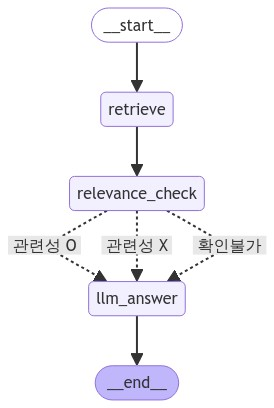

In [20]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [43]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="사물주소와 관련된 체계가 존재하는가?")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 사물주소와 관련된 체계가 존재하는가?
Answer: 	 사물주소와 관련된 체계는 존재합니다. 관련 법령인 「도로명주소법」을 바탕으로 분석된 체계가 있으며, ISO 19160-1에 제시된 주소 개념 모델에서 주소와 연관된 클래스들을 중심으로 체계를 구성하고 있습니다. 사물주소는 도로명과 기초번호를 활용하여 건물 등이 아닌 시설물의 위치를 특정하는 정보를 의미합니다.
Relevance: 	 grounded


In [65]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="네이버 지오코딩 API를 활용하는 방법은?")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 네이버 지오코딩 API를 활용하는 방법은?
Answer: 	 네이버 지오코딩 API를 활용하려면 다음과 같은 절차를 따르시면 됩니다:

1. **네이버 클라우드 플랫폼에 접속**:
   - 네이버 클라우드 플랫폼에 로그인합니다.
   - 화면 상단의 콘솔 버튼을 클릭합니다.

2. **API Key 발급**:
   - API를 활용하기 위해 API Key를 발급받아야 합니다.
   - 네이버 지오코딩 API Key는 네이버 클라우드 플랫폼에서 발급받을 수 있습니다.

3. **API 요청 구성**:
   - API 요청을 위해 필요한 형식에 맞춰 요청 URL을 작성해야 합니다.
   - 요청 헤더에는 발급받은 API Key와 아이디 값을 입력합니다.

4. **예시 코드**:
   - 아래는 간단한 API 요청 예시 코드입니다.

   ```python
   import requests as re
   import json
   
   # 요청 헤더에 API 키와 아이디 값 입력
   headers = {
       "X-NCP-APIGW-API-KEY-ID": "YOUR_API_ID",
       "X-NCP-APIGW-API-KEY": "YOUR_API_SECRET"
   }
   
   # 파라미터에는 검색할 주소 입력
   params = {
       "query": "서울특별시 동작구 흑석로 84",
       "output": "json"
   }
   
   # 정보 요청할 URL
   url = "https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode"
   
   # API 호출
   response = re.get(url, headers=headers, params=params)
   data = response.json()
   
   # 결과 출력
   print(json.dumps(data, indent=4, ensure_ascii=False))
   `

In [70]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="실내 이동경로 구간을 작성하는 방법을 알려줘")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 실내 이동경로 구간을 작성하는 방법을 알려줘
Answer: 	 실내 이동경로 구간을 작성하는 방법은 다음과 같습니다:

1. **일반원칙**:
   - 실내 이동경로 구간은 사람의 통행을 중심으로 층 단위로 작성해야 합니다.
   - 작성 단위마다 도로명, 건물번호, 동번호 등이 없는 경우 생략하고 층수를 함께 등록합니다.
   - 실내 이동경로 구간은 부여가 예상되는 상세주소 출입구 또는 사물번호 기준점을 모두 연결 가능하도록 작성합니다.
   - 건물 등의 출입구 및 내부의 수직연결점(층 간 이동과 연결되도록)과 연결되도록 작성합니다.

2. **세부기준**:
   - 하나의 층에 수직연결점이 2개 이상 있고 각 수직연결점을 주로 이용하는 상세주소 또는 사물주소 부여대상이 있는 경우, 2개 이상의 실내 이동경로 구간을 설정하고 서로 연결되도록 작성합니다.
   - 하나의 층이 연결되지 않는 두 개의 공간으로 분리되어 각 공간에 수직연결점이 있는 경우, 각 공간에 실내 이동경로 구간을 설정합니다.

3. **작성 예시**:
   - 실내 이동경로 구간은 사람의 통행을 중심으로 층 단위의 선형으로 작성합니다.
   - 시작지점은 사람의 이용이 많은 수직연결점을 기준으로 합니다.
   - 타원형의 경우에는 시계 반대 방향으로 실내 이동경로 구간을 설정합니다.

이와 같은 방법으로 실내 이동경로 구간을 작성하여야 합니다.
Relevance: 	 grounded


In [92]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="도로명주소의 시행 목적이 뭐야?")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 도로명주소의 시행 목적이 뭐야?
Answer: 	 
도로명주소법의 목적은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기, 사용, 관리, 활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지하는 것입니다.

출처: 도로명주소법.txt
Relevance: 	 grounded


In [91]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="주소정보의 개념 재정립이 필요한 이유가 뭐야?")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 주소정보의 개념 재정립이 필요한 이유가 뭐야?
Answer: 	 주소정보의 개념을 재정립하는 이유는 크게 두 가지입니다. 첫째, 2014년 도로명주소 전면 시행 이후 4차 산업혁명으로 인한 사회의 급격한 변화에 대응하기 위해서입니다. 둘째, 공법상 주소가 아닌 정보로서의 주소에 대한 관심과 필요성이 증가함에 따라, 다양한 연구에서 제시된 새로운 개념을 체계적으로 정리할 필요가 있기 때문입니다. 이러한 재정립은 도로명주소법의 개정을 앞두고 미래를 대비한 정교한 주소체계를 확립하는 데에 중요한 기반이 됩니다.

출처: 주소체계 고도화에 따른 주소정보 개념 정립 연구.pdf
Relevance: 	 grounded


In [96]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="AddressAlias의 의미와 활용 방법을 알려줘")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 AddressAlias의 의미와 활용 방법을 알려줘
Answer: 	 AddressAlias는 주소를 명확하게 식별하기 위한 대체 표현 또는 별칭을 의미합니다. 이는 언어나 문화권에 따른 표기(localeAlias), 주소의 생애주기에 따라 변화된 주소 표기(lifecycleAlias), 비공식적 또는 구어체 표기(colloquialAlias), 그리고 AddressClass의 표기(classAlias) 등에 적용될 수 있습니다. 여러 별칭이 존재할 경우, 선호도(preferenceLevel)에 따라 우선순위를 나타낼 수 있습니다. 예를 들어, 한국의 주소 클래스는 도로명 주소와 지번 주소로 구분될 수 있습니다.

출처: ISO 19160-1-2015 개념모델에 대한 분석과 이해, 김지영-양성청-도로명주소법 개정에 대비한 표준기반 사물주소 정의
Relevance: 	 grounded


In [97]:
output['context']

[(Document(metadata={'source': 'data/final/ISO 19160-1-2015 개념모델에 대한 분석과 이해.txt'}, page_content='AddressAlias 클래스는 주소를 명확하게 식별하기 위한 대체 표현 또는 별칭을 표현한다. 이 클래스는 언어나 문화권 에 따른 표기(localeAlias), 주소의 생애주기에 따라 변화된 주소 표기(lifecycleAlias), 주소의 비공식적 또는 구어체에 표기(colloquialAlias), AddressClass의 표기(classAlias) 에 적용할 수 있다. AddressClass 클래스는 동일한 주소구 성요소, 관계, 의미를 공유하는 주소 집합을 의미하고, 주소의 유형에따라확장될수있다. 예를들어, 한국의 주소클래스는 도로명주소와 지번주소로 구분할 수 있다. 별칭이 여러 개인 경우, 선호도(preferenceLevel)에 따라 우선순위를 나타 낼 수 있다.'),
  0.6787415615843314),
 (Document(metadata={'source': 'data/final/김지영-양성청-도로명주소법 개정에 대비한 표준기반 사물주소 정의.txt'}, page_content='또한 동일한 주소부여대상을 명확하게 확인하기 위하여 주소들은 AddressAlias(주소 별칭)으로 참조된다. 표준에서는 두 개의 도로 모퉁이에 접하는 하나의 건물 이 각 도로마다 출입구가 있어 출입구마다 주소가 부여된 건물을 예로 들고 있다.'),
  0.822756826877594)]

In [89]:
output['context'][1][0].metadata['source']

'data/final/주소정보_업무편람_최종(하이퍼링크).pdf'

In [98]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="python에서 pandas를 활용하여 csv 파일을 읽는 방법과 예시를 알려줘")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 python에서 pandas를 활용하여 csv 파일을 읽는 방법과 예시를 알려줘
Answer: 	 Python에서 pandas 라이브러리를 사용하여 CSV 파일을 읽는 방법은 매우 간단합니다. pandas의 `read_csv` 함수를 사용하면 됩니다. 아래는 예시 코드입니다:

```python
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv('sample.csv')

# 데이터 형태 파악하기
print(df.shape)

# 데이터의 첫 5행 출력
print(df.head(5))
```

위 코드에서는 `sample.csv` 파일을 읽어와 데이터프레임 `df`에 저장합니다. 그런 다음, `df.shape`을 사용하여 데이터의 형태(행과 열의 수)를 출력하고, `df.head(5)`을 사용하여 데이터의 첫 5행을 출력합니다.

출처: chapter-7-6, chapter-4-5
Relevance: 	 grounded


In [99]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="미키마우스는 누가 만들었어?")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 미키마우스는 누가 만들었어?
Answer: 	 미키마우스는 월트 디즈니와 애브 아이웍스가 공동으로 만든 캐릭터입니다. 미키마우스는 1928년에 처음 등장했습니다.
Relevance: 	 notGrounded


In [100]:
from langchain_core.runnables import RunnableConfig

# recursion_limit: 최대 반복 횟수, thread_id: 실행 ID (구분용)
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": "SELF-RAG"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(question="KPOP 가수 5명만 말해줘")
output = app.invoke(inputs, config=config)

# 출력 결과를 확인합니다.
print("Question: \t", output["question"])
print("Answer: \t", output["answer"])
print("Relevance: \t", output["relevance"])

Question: 	 KPOP 가수 5명만 말해줘
Answer: 	 KPOP 가수 5명은 다음과 같습니다:

1. BTS (방탄소년단)
2. BLACKPINK
3. EXO
4. TWICE
5. Red Velvet
Relevance: 	 notGrounded
